```python
# TODO: to be changed filename to: QHack2023_submission.ipynb

# TODO: to be added to repo png files with plotted graphs 

# TODO: to be added to repo csv file with calculated values for different bond lenghts
```

**`Please check especially parts marked TODO and REVIEW`**

# QHack2023 - Quantum Chemistry Challenge

**Project:** *Quantum algorithm for computing ground state energy of $BeH_{2}$*

**Description:** TODO

In [ ]:
# Install necessary libraries in Colab
!pip install qiskit qiskit-nature[pyscf] pylatexenc -U --quiet

# REVIEW: we should check what is needed to load in qBraid

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 KB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 78.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.3/241.3 KB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 KB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 74.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Import necessary libraries and packages
import math
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white' # set white background
plt.rcParams.update({"font.size": 16})  # enlarge matplotlib fonts

import numpy as np
from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

from qiskit import Aer, IBMQ, QuantumCircuit
# REVIEW: to be checked if BackendEstimator needs to be imported just before estimator initialization, as for AerEstimator
from qiskit.primitives import BackendEstimator

# REVIEW: Not present in the code, to be removed
from qiskit.providers.aer import StatevectorSimulator

# REVIEW: QuantumInstance not used in code, to be removed
# shoudl algorithm_globals be used before running construct problem? algorithm_globals.random_seed = 1024
from qiskit.utils import QuantumInstance, algorithm_globals

# REVIEW: do we need this? If so, add comment
from qiskit.tools.jupyter import *
from qiskit.visualization import *

# Import Qiskit libraries for VQE
from qiskit.algorithms import MinimumEigensolverResult, VQE

# REVIEW: We should import only the necessary, desc to be added in comment
from qiskit.algorithms.optimizers import SLSQP, SPSA, L_BFGS_B, GradientDescent

# REVIEW: Not needed, because we are creating custom ansatz
from qiskit.circuit.library import TwoLocal, EfficientSU2

# Import Qiskit Nature libraries
from qiskit_nature.algorithms import GroundStateEigensolver, VQEUCCFactory
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.circuit.library import UCC, UCCSD
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType, ElectronicStructureMoleculeDriver
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import BravyiKitaevMapper, JordanWignerMapper, ParityMapper
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem

# REVIEW: ActiveSpaceTransformer - we will not use it, right?
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer, FreezeCoreTransformer

# Prototype-zne
# REVIEW: Is it needed for error mitigation? If so, should be in the beginning of notebook
#!pip install prototype-zne --quiet

# REVIEV: what is it for? comment needed or remove
from qiskit_nature.settings import settings
settings.dict_aux_operators = True

## $BeH_{2}$ molecule definition

Bond length is a distance between each adjacent atom that we will define in [Angstrom](https://en.wikipedia.org/wiki/Angstrom) metric units. The bond length is an important factor in determining the strength of the bond between the atoms. The shorter the bond length, the stronger it is.

In [ ]:
# bond length in Angstrom
distance = 1.7

# Molecule geometry
beh2 = [["Be", [ 0.0,    0.0,    0.0]], 
        ["H", [ 0.0,    0.0,   -distance]],
        ["H", [ 0.0,    0.0,   distance]]]

### Electronic structure problem

After specifying atomic coordinates (geometry), we need to initiate chemical driver (problem) according to the molecule total spin (multiplicity) and charge information and with one of available basis sets. For our calculations we have chosen [STO-3G](https://en.wikipedia.org/wiki/STO-nG_basis_sets).

After defining driver we can perform preliminary calculations and try to reduce the size of the problem to solve by using transformer that can reduce the problem to a configured active space.

In [ ]:
def construct_problem(geometry, charge, multiplicity, basis="sto3g", freeze_core=True, remove_orbitals=None, maxiter=50):
    """
    Function for constructing molecule as Electronic structure problem with STO-3G basis set (default),
    reducing number of required qubits for calculation by freezing lowest electron orbitals and removing inactive orbitals
    and performing preliminary Quantum Chemistry calculation using PySCF    
    """
    molecule = Molecule(geometry=geometry,charge=charge, multiplicity=multiplicity)
    driver = ElectronicStructureMoleculeDriver(molecule, basis=basis, driver_type=ElectronicStructureDriverType.PYSCF)

    # Run the preliminary quantum chemistry calculation
    properties = driver.run()

    # Freezing lowest electron orbitals (freeze_core=True) and removing inactive orbitals (integer list)
    freezeCoreTransformer = FreezeCoreTransformer(freeze_core=freeze_core,remove_orbitals=remove_orbitals)

    # Now you can get the reduced electronic structure problem
    problem_reduced = ElectronicStructureProblem(driver, transformers=[freezeCoreTransformer])

    # The second quantized Hamiltonian (fermionic operator) of the reduced problem for electronic energy
    fermionic_ops = problem_reduced.second_q_ops().get('ElectronicEnergy')

    return problem_reduced, fermionic_ops, properties

#### Reduced problem

Transformer `FreezeCoreTransformer`, that we have chosen, allow to specify orbitals to be removed by means of two variables:
- `freeze_core` - enabled by default, the "core" orbitals will be determined automatically according to count_core_orbitals. These will then be made inactive and removed in the same fashion as in the [`ActiveSpaceTransformer`](https://qiskit.org/documentation/nature/locale/bn_BN/stubs/qiskit_nature.second_q.transformers.ActiveSpaceTransformer.html#activespacetransformer).
- `remove_orbitals` - unoccupied spatial orbitals can be removed by setting a list of indices. 

**Note:** Before doing that, we have ensured that orbitals to be removed are unoccupied ones.

Reducing problem results in qubit mapping that requires less qubits for algorithm definition.

TODO: describe partially reduced problem, show results without freeze and orbitals removal

In [ ]:
# TODO: comment
problem_reduced, fermionic_ops, properties = construct_problem(geometry=beh2, charge=0, multiplicity=1, basis="sto3g", freeze=True, remove_orbitals=[3,4])

# Number of qubits after initial reduction
print(f"Fermionic operator has been mapped to {fermionic_ops.register_length} qubits")

Fermionic operator has been mapped to 8 qubits


In [ ]:
# Electronic structure properties
print(properties)

ElectronicStructureDriverResult:
	DriverMetadata:
		Program: PYSCF
		Version: 2.1.1
		Config:
			atom=Be 0.0 0.0 0.0;H 0.0 0.0 -1.7;H 0.0 0.0 1.7
			unit=Angstrom
			charge=0
			spin=0
			basis=sto3g
			method=rhf
			conv_tol=1e-09
			max_cycle=50
			init_guess=minao
			max_memory=4000
			
	ElectronicBasisTransform:
		Initial basis: atomic
		Final basis: molecular
		Alpha coefficients:
		[0, 0] = 0.9919712737115951
		[0, 1] = -0.21012281570259556
		[0, 2] = 1.8743843210200245e-16
		[0, 3] = 1.0477711636981899e-18
		[0, 4] = -6.479192564948017e-19
		[0, 5] = -0.22831220797367535
		[0, 6] = -2.6072005335247126e-16
		[1, 0] = 0.030421514549834845
		[1, 1] = 0.6331724350282515
		[1, 2] = -5.088317389978074e-16
		[1, 3] = -1.808759683031049e-17
		[1, 4] = 1.8005260696145327e-17
		[1, 5] = 0.9804703496044787
		[1, 6] = 1.2461788081980166e-15
		[2, 0] = 2.9601198756957004e-34
		[2, 1] = 8.67664289006452e-33
		[2, 2] = -1.5627980518435264e-16
		[2, 3] = -0.4009918721448182
		[2, 4] = 0.9160816

#### More reductions

We decided to find the simplest Hamiltonian possible, so that on noisy device the circuit is more shallow, so that there will be less noise to mitigate. In Qiskit tutorial [Simulating Molecules using VQE](https://qiskit.org/textbook/ch-applications/vqe-molecules.html#Problems) is information for $BeH_{2}$ molecule about possibility to use qubit tapering operations to reduce the number of required qubits to 7, without losing any chemical precision (being within 0.0016 [Hartree](https://en.wikipedia.org/wiki/Hartree) of the exact result).

TODO: Add info and reference to paper describing possibility to reduce to 5 qubits in BeH2

In [ ]:
# Function for a given problem maps fermionic operator to qubits and converts with Pauli operators reduction
def reduction(problem_reduced, fermionic_ops, mapper, two_qubit_reduction=False, z2symmetry_reduction=None):
  """
  TODO: description
  mapper: one of the available in Qiskit Nature mappers: ParityMapper(), JordanWignerMapper(), BravyiKitaevMapper()
  two_qubit_reduction: TODO: description
  z2symmetry_reduction: TODO: description
  """

  # Set the qubit converter with two qubit reduction to reduce the computational cost 
  converter = QubitConverter(mapper, two_qubit_reduction=two_qubit_reduction, z2symmetry_reduction=z2symmetry_reduction)

  # Compute the Hamitonian in qubit form
  qubit_op = converter.convert(fermionic_ops, num_particles=problem_reduced.num_particles)
  
  return converter, qubit_op

#### Qubit tapering with Z2 symmetries

Qubit tapering is a technique used in Quantum Computing to reduce the number of qubits needed to simulate a quantum system. This technique leverages the presence of certain symmetries in the system to identify a subset of qubits that can be eliminated without affecting the calculation results.

Z2 symmetry refers to a property of a quantum state that is invariant under the action of the Z2 group, which consists of two elements: 
- I - the identity element, represented by the number 1), 
- Pauli-Z gate - represented by the number -1.

In Qiskit Nature [`QubitConverter`](https://qiskit.org/documentation/nature/stubs/qiskit_nature.second_q.mappers.QubitConverter.html) supports Z2 symmetry reduction.

In [ ]:
from qiskit.opflow.primitive_ops import Z2Symmetries, PauliSumOp, TaperedPauliSumOp

# Reduce problem
converter, qubit_op = reduction(problem_reduced, fermionic_ops, mapper=BravyiKitaevMapper())

# Find Z2 symmetries for qubit tapering
z2symmetries = Z2Symmetries.find_Z2_symmetries(qubit_op)
print(z2symmetries)

Z2 symmetries:
Symmetries:
IIIIZIII
IZIZIZIZ
ZIIIIIII
Single-Qubit Pauli X:
IIIIXIII
IIIIIIIX
XIIIIIII
Cliffords:
0.7071067811865475 * IIIIZIII
+ 0.7071067811865475 * IIIIXIII
0.7071067811865475 * IZIZIZIZ
+ 0.7071067811865475 * IIIIIIIX
0.7071067811865475 * ZIIIIIII
+ 0.7071067811865475 * XIIIIIII
Qubit index:
[3, 0, 7]
Tapering values:
  - Possible values: [1, 1, 1], [1, 1, -1], [1, -1, 1], [1, -1, -1], [-1, 1, 1], [-1, 1, -1], [-1, -1, 1], [-1, -1, -1]


#### Reduction to 5-qubit hamiltonian

REVIEW: `reduction()` could be used with ParityMapper and JordanWignerMapper for comparison with final BravyiKitaevMapper and converter with z2symmetry_reduction=[1, 1, 1]

In [ ]:
# Reduction of the problem to 5-qubit hamiltonian with use of Z2 symmetry reduction for values [1, 1, 1]
converter, qubit_op = reduction(problem_reduced, fermionic_ops, mapper=BravyiKitaevMapper(), z2symmetry_reduction=[1,1,1])
print(qubit_op)

-2.1251355411798682 * IIIII
+ 0.09658465993433141 * ZIZZI
- 0.001962891713328568 * IIIYY
+ 0.001962891713328568 * ZIZYY
+ 0.0785764634748828 * ZIZZZ
- 0.008851618031181523 * ZIZZX
+ 0.008851618031181523 * IIIZX
- 0.08569031782260991 * IIIZI
- 0.2187311583739367 * IIIZZ
+ 0.09658465993433146 * IIZII
- 0.001962891713328567 * YYXII
+ 0.001962891713328567 * XYYII
+ 0.07857646347488272 * IZZII
- 0.008851618031181528 * IXZII
+ 0.008851618031181528 * ZXIII
- 0.08569031782260991 * ZIIII
- 0.21873115837393672 * ZZIII
+ 0.11989911663595663 * IIIIZ
- 0.0076937912107231336 * IIIIX
+ 0.0076937912107231336 * ZIZIX
+ 0.2945029108928997 * ZIZII
+ 0.15347080904163074 * ZIZIZ
+ 0.00514074256442611 * ZIZXX
- 0.00514074256442611 * IIIXX
- 0.009110140443095317 * ZIZXZ
+ 0.03676479981578867 * IIIXI
- 0.027654659372693353 * IIIXZ
+ 0.18603220836053874 * ZIIZI
- 0.003900690257491414 * IIZYY
+ 0.003900690257491414 * ZIIYY
+ 0.03868205812444731 * IZXIZ
- 0.03868205812444731 * IIXIZ
- 0.03868205812444731 * IZXII

#### Calculate reference ground state energy

We need to compare the calculated values with reference value (exact ground state energy), so in function `simulated_results` we will employ the Unitary Couple Cluster (UCCSD) ansatz as our variational form and the Sequential Least Squares Programming (SLSQP) optimizer.

In [ ]:
# Get reference solution by simulating on statevector simulated quantum instance and ansatz
def simulated_results(maxiter=50): 
  vqe_factory = VQEUCCFactory(quantum_instance=Aer.get_backend("aer_simulator_statevector"),optimizer=SLSQP(maxiter=maxiter),
                              ansatz=UCC(excitations='sd') # UCC"SD" ansatz
                            )
  solver = GroundStateEigensolver(converter, vqe_factory)    
  reference_value = solver.solve(problem_reduced).total_energies[0]
  ansatz=vqe_factory.ansatz
  return reference_value, ansatz

In [ ]:
# REVIEW: Is the random_seed needed for simulated results? If so, comment needed
algorithm_globals.random_seed = 1024

# Calculate ground state energy on simulated backend
reference_value, ansatz = simulated_results()
print("Reference value:", reference_value)

Reference value: (-15.523353144062066+0j)


### Variational Quantum Eigensolver (VQE)

In quantum computing, the Variational Quantum Eigensolver (VQE) is a hybrid quantum-classical algorithm used to find the ground state energy of a given Hamiltonian. The VQE algorithm involves preparing a quantum state using a parametrized quantum circuit called an `ansatz`, and then optimizing the parameters of the circuit to minimize the energy of the Hamiltonian.

The choice of the ansatz is an important factor in the VQE algorithm, as it determines the expressiveness of the circuit and the computational resources required to run the algorithm. An ansatz with more parameters and deeper circuit depth (like UCCSD) can represent more complex quantum states, but requires more computational resources to simulate and run on a quantum device.

Due to the limitations of current NISQ (Noisy Intermediate-Scale Quantum) devices, it is often more feasible to use shallower circuits with fewer parameters in the VQE algorithm. This is because the higher error rates and limited coherence times of NISQ devices can make it challenging to simulate and execute deep circuits accurately.

A common strategy in VQE is to start with a simple, shallow ansatz and gradually increase its complexity until the desired accuracy is achieved. This approach allows the algorithm to be run on NISQ devices while still exploring a wide range of quantum states.

#### Parametrized quantum circuit (ansatz)

Circuit depth: 24


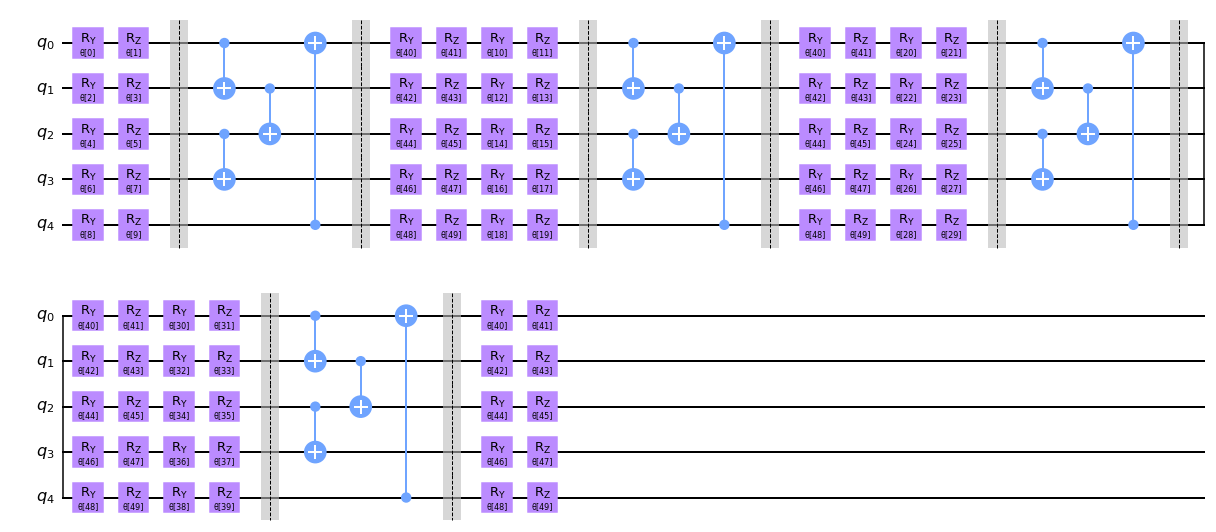

In [ ]:
from qiskit.circuit import ParameterVector

# number of qubits for reduced problem with tapered qubits
n_qubit = 5

# number of layers of parametrized custom circuit (ansatz)
depth = 4

custom_ansatz = QuantumCircuit(n_qubit)
theta = ParameterVector('θ', n_qubit*depth*4)# rx +6)

for d in range(depth):
  for i in range(n_qubit):
    custom_ansatz.ry(theta[2*i+2*n_qubit*d], i)
    custom_ansatz.rz(theta[2*i+1+2*n_qubit*d], i)
  custom_ansatz.barrier()
  for i in range(n_qubit//2):
    custom_ansatz.cx(2*i, 2*i+1)
  for i in range(n_qubit//2-1):
    custom_ansatz.cx(2*i+1, 2*i+2)
  custom_ansatz.cx(n_qubit-1, 0)
  custom_ansatz.barrier()
  for i in range(n_qubit):
    custom_ansatz.ry(theta[2*i+2*n_qubit*depth], i)
    custom_ansatz.rz(theta[2*i+1+2*n_qubit*depth], i)
    #if d == 0:
    #  custom_ansatz.rx(theta[2*i+1+2*n_qubit*depth], i)

print("Circuit depth:", custom_ansatz.depth())
custom_ansatz.draw('mpl')

For comparison, we can check how big was initial ansatz created with UCCSD method.

In [ ]:
# UCCSD circuit depth
print("UCCSD circuit depth:", ansatz.decompose(reps=3).depth())

### TODO: description of VQE and custom VQE class

We have defined a custom VQE class to orchestrate the ansatz, classical optimizers, initial point, callback, and final result.

In [ ]:
from qiskit.algorithms import MinimumEigensolver, VQEResult, MinimumEigensolverResult

params_history = []

class CustomVQE(MinimumEigensolver):

    def __init__(self, estimator, circuit, optimizer, problem=None, callback=None, aux_operators=None):
        self._estimator = estimator
        self._circuit = circuit
        self._optimizer = optimizer
        self._problem = problem
        self._callback = callback
        
    def compute_minimum_eigenvalue(self, operators, initial_point=None):

        # Define objective function to classically minimize over
        def objective(x):
            
            # Execute job with estimator primitive
            x = list(x)
            job = self._estimator.run([self._circuit], [operators], [x])

            # Add parameters to history
            params_history.append(x)

            # Get results from jobs
            est_result = job.result()
            
            # Get the measured energy value
            value = est_result.values[0]
            
            # Interpret results (add nuclear repulsion energy)
            sol = MinimumEigensolverResult()
            sol.eigenvalue = value
            sol = self._problem.interpret(sol).total_energies[0]

            # Save result information using callback function
            if self._callback is not None:
                self._callback(np.real(sol))
            return np.real(sol)

        # Select an initial point for parametrized circuit
        if initial_point is None:
            initial_point = np.random.rand(self._circuit.num_parameters)
        
        #print(self._initial_point)
        # TODO: Initial point as parameter
        res = self._optimizer.minimize(objective, x0=initial_point)#, bounds=[-18.5,-16])#self._initial_point)

        # Populate VQE result
        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_value = res.fun
        result.optimal_parameters = res.x

        return result, params_history

### TODO: describe VQE setting for BeH2 simulation, why optimizer SLSQP, etc.

In [ ]:
# AerEstimator need to be imported before estimator initialization
from qiskit_aer.primitives import Estimator as AerEstimator

In [ ]:
# Define instance of Aer Estimator primitive for faster runs
estimator = AerEstimator([custom_ansatz], [qubit_op], backend_options={'method':'statevector'}, run_options={'shots':None}, approximation=True)

# Define a simple callback function returning interpreted eigenvalue
intermediate_info = []
def callback(value):
        # Overwrites the same line when printing
        display("Energy: {}".format(value))
        clear_output(wait=True)
        intermediate_info.append(value)

# Choose optimizer and set maximum number of iterations
optimizer = SLSQP(maxiter=500)

# Calculate for deterministic and 
initial_point = np.ones(custom_ansatz.num_parameters) * np.pi/4

#### TODO: calculate VQE for deterministic and random `initial_point`

In [ ]:
# Plots graph with expectation values results for reach function evaluation
def plot_graph(energy, reference_value, molecule, color="tab:blue", save=None):
    
    plt.rcParams["font.size"] = 14

    # plot loss and reference value
    plt.figure(figsize=(12, 6), facecolor='white')
    plt.plot(energy, label="Estimator VQE {}".format(molecule),color = color)
    plt.grid()
    plt.axhline(y=reference_value.real-0.0016, color="tab:green", ls="--", lw=2, label="-0.0016 Hartree")
    #plt.text(x=0,y=0.0005+reference_value.real+0.0016,s='+0.0016',color="green")
    plt.text(x=0,y=0.0005+reference_value.real+0.0016,s='Chemical accuracy',color="green")
    plt.axhline(y=reference_value.real, color="tab:red", ls="--", label="Target")
    plt.axhline(y=reference_value.real+0.0016, color="tab:green", ls="--", lw=2, label="+0.0016 Hartree")
    #plt.text(x=0,y=0.0005+reference_value.real-0.0016,s='-0.0016',color="green")
    plt.legend(loc="best")
    plt.xlabel("# Evaluations")
    plt.ylabel("Energy [Hartree]")
    plt.title("VQE energy")
    if save:
      plt.savefig(fname=f"{molecule}_Energy.png", bbox_inches='tight', transparent=False)
    plt.show()

#### TODO: describe training

In [ ]:
%%time
# Setup VQE algorithm
intermediate_info = []
custom_vqe = CustomVQE(estimator, custom_ansatz, optimizer, problem_reduced, callback=callback)

# Run the custom VQE function and monitor execution time
result, params_history = custom_vqe.compute_minimum_eigenvalue(qubit_op, initial_point=initial_point)

CPU times: user 2min 35s, sys: 6.52 s, total: 2min 42s
Wall time: 3min 15s


Relative error: 0.0078 %  =  0.0012039322219656867 Ha


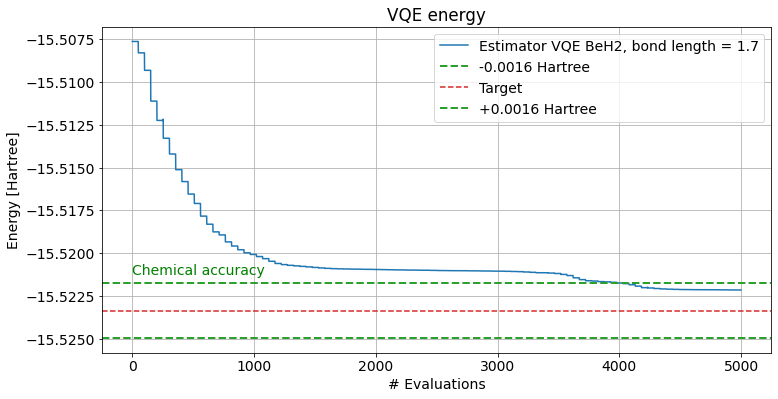

Optimal parameters: [ 8.52178281e-01  2.21222695e+00  1.36686708e+00  1.42889200e+00
  1.58719253e+00  1.01079468e-01  1.19281453e+00  6.67422949e-02
  1.83518732e+00  4.18488563e-01  1.46168618e+00  1.54014674e+00
  1.43038087e-01  5.67119830e-01  1.74121591e+00  3.25376156e-02
  1.25194603e+00  2.50029504e-02  3.10103525e-01  9.69752278e-01
 -1.07805683e-01  2.83990259e+00  6.15313679e-01  1.12560171e-01
  9.12073794e-01  2.22029964e+00  1.55004759e+00 -3.65480642e-02
  1.84442406e+00  8.30384118e-01  1.85293465e+00 -1.72256392e+00
  7.12971149e-03  4.01585250e-01  9.66291069e-01  1.11716661e+00
  1.60154065e+00  1.39872459e-01  1.51009696e-02  6.17138573e-01
  1.63861440e+00  1.65937696e-01  1.27180568e+00  1.14805424e+00
 -1.12279107e-01  1.13736690e+00  1.56990245e+00  1.33039074e+00
 -2.26329652e-03  1.67630279e+00]


In [ ]:
# Plot Graph BeH2
energy = intermediate_info.copy()
print("Relative error:", np.round(np.abs((energy[-1].real-reference_value)/reference_value*100),4), "%", " = ", np.abs(energy[-1].real-reference_value), "Ha")

plot_graph(energy[-5000:], reference_value, molecule=f"BeH2, bond length = {distance}", color="tab:blue", save=None)
print("Optimal parameters:", result.optimal_parameters)